## 3. Regression model

### 1 Problem and Overview
The gallstone status prediction is a classisification problem. This particular dataset present a few challenges: 
- small sample size
- potential gender imbalance
- excessive and correlated features

Our goal is to build and evaluate models that are robust, generalizable, and interpretable. In this notebook We will use LogisticRegression with elasticnet solver that combines L1 (LASSO) and L2 (Ridge) regularization. To stabilize models we apply cross validation (CV) and nested CV. We also demonstrate a feature selection strategy based on the outcome of LASSO fitting and effects of data stratification.


 Number or metrics (roc_auc, accuracy, recall) are evaluated for pipelines, for hyperparameter tuning in GridCV and nested CV roc_auc score is used.


In [252]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

path_train_data = "data/train_data_fold_split.csv"
path_test_data = "data/test_data.csv"
path_train_data_strat = "data/train_data_fold_split_strat.csv"
path_test_data_strat = "data/test_data_strat.csv"

### 2. Splitting Strategy

To ensure reproducibility and avoid data leakage:

- 30% held out as test set for final evaluation.

- 70% training set used for model development.

Two stratification strategies tested:

Gallstone only (standard clinical outcome stratification).

Gallstone + Gender (to account for gender imbalance in gallstone prevalence).

We load the data and read in splits for 5-fold cross-validation. We drop features that are highly skewed (hyperlipidemia, hypothyroidism, cad) since they have just a few positive samples and would rather create noise.

In [253]:
train_data = pd.read_csv(path_train_data)
test_data  = pd.read_csv(path_test_data)

folds = train_data[[c for c in train_data.columns if c.startswith("Fold")]]
fold_names = folds.columns.to_list()
strat_columns = ["strat"]
exclude_features = ["hyperlipidemia", "hypothyroidism", "cad"]

X_train = train_data.drop(fold_names + ["gallstone"] + strat_columns + exclude_features, axis = 1)
y_train = train_data["gallstone"]
X_test = test_data.drop(["gallstone"] + strat_columns + exclude_features, axis = 1)
y_test = test_data["gallstone"]

splits = []

for fold in fold_names:
    train_idx =  folds.index[folds[fold] == "train"].to_numpy()
    val_idx = folds.index[folds[fold] == "val"].to_numpy()
    splits.append((train_idx.tolist(), val_idx.tolist()))

### 3 Model evaluation concept

For evaluation we will check scores on each fold separately, the whole train set and the test set. For fold score the model is trained on the fold train data and tested on the fold validation set. After that the model is retrained on the whole train data and the scores on the train data (for consistency) and the test data are evaluated. The scores are saved in json-like style that makes it easy to save pipeline results (optionally) or to combine them to a dataframe.

In [254]:
metrics_scores = { 
    "accuracy": accuracy_score, 
    "f1": f1_score, 
    "precision": precision_score, 
    "recall": recall_score, 
    "roc_auc": roc_auc_score 
    } 

def get_pipeline_results(pipeline, name = "model", fold_names = fold_names, splits = splits, X_train = X_train, y_train=y_train, X_test = X_test, y_test = y_test, metrics = ["accuracy", "roc_auc"]):
    ''' 
    Get scores for pipeline: for each metric in metrics followng values are calculated: CV in folds, CV mean, CV std, metric on the train set and metric on the test set
    ''' 
    results = {"name": name, "scores": {}, "coef": {}} 
    results["scores in folds"] = {f"{m.capitalize()} CV in folds": {} for m in metrics}
    for i, (train_idx, val_idx) in enumerate(splits):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx] 
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx] 
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict(X_val_fold)
        for m in metrics: 
        #cv metric in folds 
            fold_scores = [] 
            #results["scores in folds"][f"{m.capitalize()} CV in folds"] = {} 
            if m == "roc_auc": 
                y_proba= pipeline.predict_proba(X_val_fold)[:, 1] 
                fold_score = metrics_scores[m](y_val_fold, y_proba) 
            else: 
                 
                fold_score = metrics_scores[m](y_val_fold, y_pred)
            fold_scores.append(fold_score) 
            results["scores in folds"][f"{m.capitalize()} CV in folds"][fold_names[i]] = fold_score 
        # cv metric mean and std 
        # results["scores"][f"{m.capitalize()} CV mean"] = np.mean(fold_scores) 
        # results["scores"][f"{m.capitalize()} CV std"] = np.std(fold_scores) 
        # # metric on train and test that were calculated earlier
        # results["scores"][f"{m.capitalize()} train"] = scores["train"][m]
        # results["scores"][f"{m.capitalize()} test"] = scores["test"][m] 
    
    pipeline.fit(X_train, y_train)
    results["coef"] = dict(zip(X_train.columns.tolist(), pipeline.named_steps["logreg"].coef_[0]))
    scores = {"train":{}, "test":{}} # save scores for better ordering 
    # loop through metrics first time when the pipeline is fit to full train set
    for m in metrics:
        # cv metric mean and std 
        results["scores"][f"{m.capitalize()} CV mean"] = np.mean([v for k, v in results["scores in folds"][f"{m.capitalize()} CV in folds"].items()]) 
        results["scores"][f"{m.capitalize()} CV std"] = np.std([v for k, v in results["scores in folds"][f"{m.capitalize()} CV in folds"].items()])
        # metric on train and test 
        if m == "roc_auc": 
            results["scores"][f"{m.capitalize()} train"] = metrics_scores[m](y_train, pipeline.predict_proba(X_train)[:, 1]) 
            results["scores"][f"{m.capitalize()} test"] = metrics_scores[m](y_test, pipeline.predict_proba(X_test)[:, 1]) 
        else: 
            results["scores"][f"{m.capitalize()} train"] = metrics_scores[m](y_train, pipeline.predict(X_train)) 
            results["scores"][f"{m.capitalize()} test"] = metrics_scores[m](y_test, pipeline.predict(X_test))
        # results["scores in folds"][f"{m.capitalize} CV in folds"] = {}
    # loop thorough metrics second time to fit pipeline to folds train sets
    
    return results
        
def show_pipeline_summary(results): 
    ''' 
    Shows summary of scores for a list of pipelines results without scores for individual folds 
    ''' 
    results_summary = [ 
        {"name":  res["name"], **res["scores"]}
        for res in results 
        ] 
    df = pd.DataFrame(results_summary) 
    display(df.style.hide(axis = "index").format()) 

def show_pipeline_folds(results, metrics = ["accuracy", "roc_auc"], plot = True, show_tables = True): 
    ''' 
    Shows scores for individual folds for a list of pipeline results for a list of metrics
    ''' 
    results_folds = []
    for m in metrics:
        results_folds_metric = [
            {"name": res["name"], **v}
            for res in results
            for k, v in res["scores in folds"].items() if m.capitalize() in k]
        results_folds.append(pd.DataFrame(results_folds_metric).set_index("name"))
    if show_tables:
        for m, df in zip(metrics, results_folds):
            display(df.T.style.set_caption(f"{m.capitalize()} in CV folds").format())
    if plot:
        for m, df in zip(metrics, results_folds):
            df.T.plot(figsize=(15, 5), title = f"{m.capitalize()} in CV folds", xlabel = "Folds", ylabel = m.capitalize()).legend(bbox_to_anchor=(1.0, 1.0), fontsize='small')


def show_pipeline_coef(results):
    results_coef = [
        {"name": res["name"], **res["coef"]}
        for res in results
    ]
    df = pd.DataFrame(results_coef).fillna(0).set_index("name")
    display(df.T.style
            .background_gradient(cmap="coolwarm",
                                 axis = 0,
                                 vmin = -1.5,
                                 vmax = 1.5)
            .set_table_styles([{'selector':'th',
                            'props':[('word-wrap', ' break-word'),
                                     ('width','100px'),
                                     ( 'text-align', 'center')
                                    ]
                           }])
            .format(precision = 3 )) 


### 4.Model selection
#### 4.1. Baseline Model

We start with a simple Logistic Regression with elasticnet and l1_ratio = 0.5. This baseline provides a reference performance. From now on we use the train/test split stratified on the gallstone status that provides balanced datasets.

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test
baseline,0.757576,0.055464,0.854545,0.810526,0.829477,0.054450,0.932397,0.846631


name,baseline
Fold1_Rep1,0.727273
Fold2_Rep1,0.750000
Fold3_Rep1,0.659091
Fold4_Rep1,0.863636
Fold5_Rep1,0.818182
Fold1_Rep2,0.772727
Fold2_Rep2,0.795455
Fold3_Rep2,0.795455
Fold4_Rep2,0.704545
Fold5_Rep2,0.750000


name,baseline
Fold1_Rep1,0.741736
Fold2_Rep1,0.853306
Fold3_Rep1,0.789256
Fold4_Rep1,0.925620
Fold5_Rep1,0.873967
Fold1_Rep2,0.816116
Fold2_Rep2,0.824380
Fold3_Rep2,0.873967
Fold4_Rep2,0.752066
Fold5_Rep2,0.818182


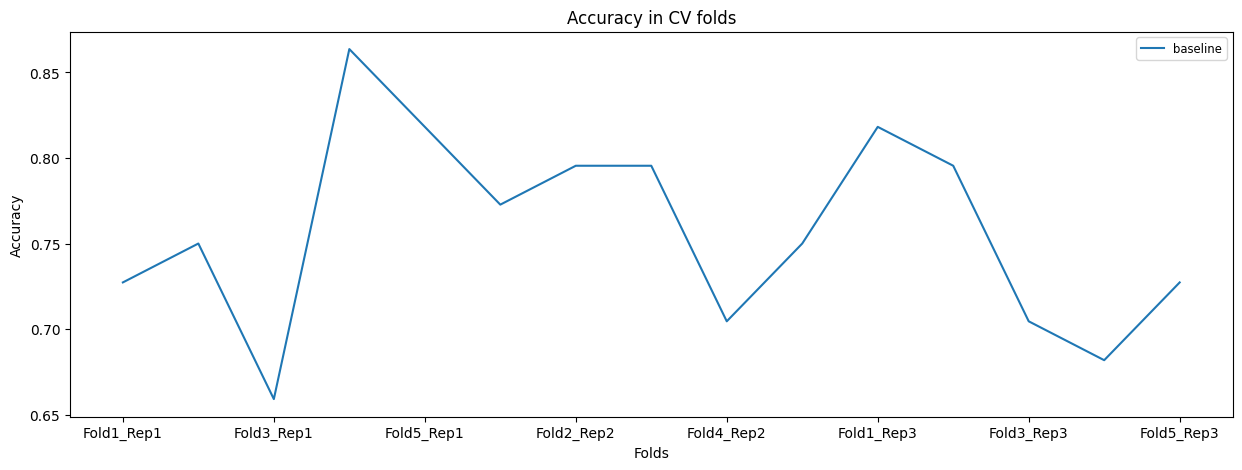

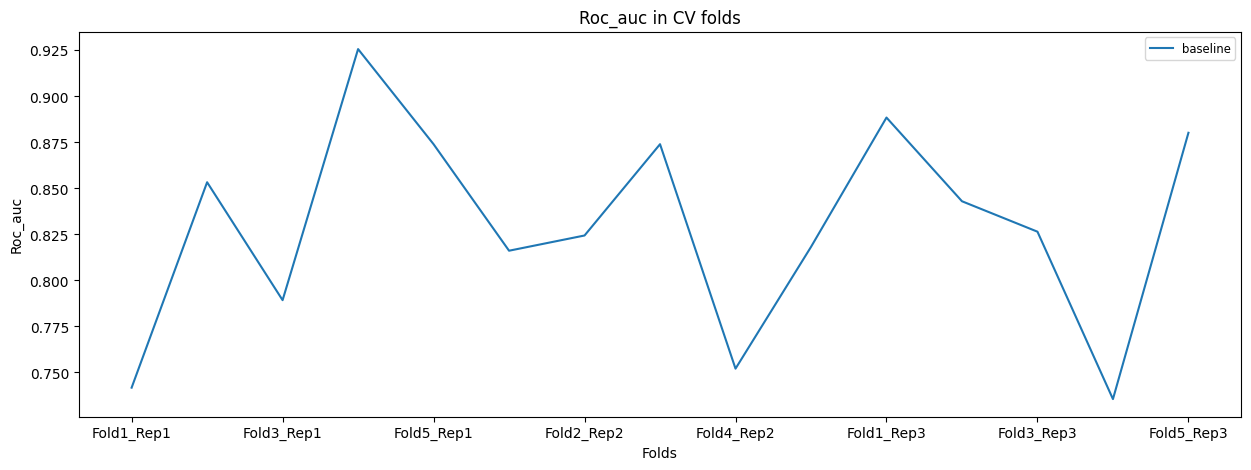

In [255]:
# baseline 
pipelines_results = []

pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 1,
        l1_ratio=0.5
    ))
])


pipelines_results.append(get_pipeline_results(pipeline_1, name="baseline"))
show_pipeline_summary(pipelines_results)
show_pipeline_folds([get_pipeline_results(pipeline_1, name="baseline")])


The baseline model performs well on the test set, but mean CV performance on folds is lower, so the test results could be over optimistic. 

#### 4.2. GridCV Model

We now ehnance the regularization by tuning hyperparameters (C and l1_ration) on 5-fold CV splits that are already prepared in the train data file. Roc_auc was chosen for scoring accuracy in folds as it balances accuracy and recall and is standard in biomedical modelling. GridCV provides a more stable model compared with the baseline.

In [256]:
# cv on predefined splits

scoring_gridcv = "roc_auc"

pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000,
        random_state=42))
])

param_grid = {
    "logreg__C": [0.001, 0.01, 0.1, 1],
    "logreg__l1_ratio": [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
}

grid_2 = GridSearchCV(
    estimator=pipeline_2,
    param_grid=param_grid,
    cv=splits,
    scoring=scoring_gridcv,
    verbose=0
)

grid_2.fit(X_train, y_train)

pipeline_2_best = grid_2.best_estimator_
print("Grid 2 Best parameters:", grid_2.best_params_)

pipelines_results.append(get_pipeline_results(pipeline_2_best, name="gridcv"))
show_pipeline_summary(pipelines_results)

Grid 2 Best parameters: {'logreg__C': 1, 'logreg__l1_ratio': 0.9}


name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test
baseline,0.757576,0.055464,0.854545,0.810526,0.829477,0.054450,0.932397,0.846631
gridcv,0.757576,0.059652,0.850000,0.800000,0.832645,0.050067,0.933306,0.845301


The variance of Roc_auc in cv folds (the metric that was optimized by GridCV) decreases slightly. It shows that the model becomes more stable.

#### 4.3. Nested CV

Next we add nested CV to the model. The nested CV provides an unbiased estimate of generalization error as it tunes hyperparameters in an inner loop (3-fold CV here) and uses outer loop with 5-fold CV to evaluate errors. This goves a more conservative but realistic generalization estimate.

The inner CV should use the same stratification that the outer CV, hence the gallstone status.

In [257]:
# nested cv

nested_cv_fold_scores = []
nested_cv_fold_best_params = []

for i, (train_idx, val_idx) in enumerate(splits):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    strat_fold = y_train.iloc[train_idx]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold, strat_fold)

    pipeline_3_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga",
        random_state=42))
])
    grid_3 = GridSearchCV(
        estimator=pipeline_3_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_3.fit(X_train_fold, y_train_fold)   # inner CV tuning happens here
    score = grid_3.score(X_val_fold, y_val_fold)   # outer validation
    best_params = grid_3.best_params_
    nested_cv_fold_scores.append(score)
    # print(f"{fold_names[i]} Grid 3 Best parameters: {best_params} best score: {score}")
    nested_cv_fold_best_params.append(best_params)

nested_cv_best_params = nested_cv_fold_best_params[np.argmax(nested_cv_fold_scores)]
pipeline_3 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_best_params['logreg__C'],
        l1_ratio=nested_cv_best_params['logreg__l1_ratio']
    ))
])
print(nested_cv_best_params)
pipelines_results.append(get_pipeline_results(pipeline_3, name="nested cv"))
show_pipeline_summary(pipelines_results)


{'logreg__C': 1, 'logreg__l1_ratio': 1}


name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test
baseline,0.757576,0.055464,0.854545,0.810526,0.829477,0.054450,0.932397,0.846631
gridcv,0.757576,0.059652,0.850000,0.800000,0.832645,0.050067,0.933306,0.845301
nested cv,0.759091,0.054923,0.850000,0.810526,0.832645,0.049799,0.933636,0.843972


CV Roc_auc std drops further confirming the model stabilization.

### 5 Feature Selection

Test results are good, but 38 features risk overfitting and limit clinical usability. There are several strategies to reduce feature dimensionality that include e.g. principal component analysis (PCA) or f1-score. Here, we use LASSO penalization to select features: during the fit LASSO pushes coefficients of irrelevant or noisy features to zero. 

#### 5.1. LASSO model

To select features we build a simple model with l1_ratio = 1 and then inspect the features with non-zero weights. 

In [258]:
# Lasso strong
pipeline_4 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 0.25,
        l1_ratio = 1
    ))
])

pipeline_4.fit(X_train, y_train)
pipelines_results.append(get_pipeline_results(pipeline_4, name="Lasso"))

# print("Pipeline 4 coefs:")
# for (k, v) in zip(X_train.columns, pipeline_4.named_steps["logreg"].coef_[0]):
#     if v != 0:
#         print(f"{k}: {v}")

lasso_features = [X_train.columns[i] for (i, v) in enumerate(pipeline_4.named_steps["logreg"].coef_[0]) if v != 0]
print(f"Lasso features ({len(lasso_features)}): {lasso_features}")

Lasso features (14): ['gender', 'diabetes', 'icw', 'ecf_tbw', 'tbfr', 'bm', 'obesity', 'vfa', 'hfa', 'hdl', 'ast', 'crp', 'hgb', 'vitamin_d']


#### 5.2. Nested CV with selected features

We now retrain nested CV using selected features only.

In [259]:
# nested cv lasso features

X_train_lasso = X_train[lasso_features]
X_test_lasso = X_test[lasso_features]

nested_cv_lasso_fold_scores = []
nested_cv_lasso_fold_best_params = []

for i, (train_idx, val_idx) in enumerate(splits):
    X_train_fold, X_val_fold = X_train_lasso.iloc[train_idx], X_train_lasso.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    strat_fold = y_train.iloc[train_idx]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold, strat_fold)

    pipeline_5_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga",
        random_state=42))
])
    grid_5 = GridSearchCV(
        estimator=pipeline_3_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_5.fit(X_train_fold, y_train_fold)   # inner CV tuning happens here
    score = grid_5.score(X_val_fold, y_val_fold)   # outer validation
    best_params = grid_5.best_params_
    nested_cv_lasso_fold_scores.append(score)
    # print(f"{fold_names[i]} Grid 5 Best parameters: {best_params} best score: {score}")
    nested_cv_lasso_fold_best_params.append(best_params)

nested_cv_lasso_best_params = nested_cv_lasso_fold_best_params[np.argmax(nested_cv_lasso_fold_scores)]
pipeline_5 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_lasso_best_params['logreg__C'],
        l1_ratio=nested_cv_best_params['logreg__l1_ratio']
    ))
])

pipelines_results.append(get_pipeline_results(pipeline_5, name="nested cv lasso features", X_train=X_train_lasso, X_test=X_test_lasso))

show_pipeline_summary(pipelines_results)

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test
baseline,0.757576,0.055464,0.854545,0.810526,0.829477,0.054450,0.932397,0.846631
gridcv,0.757576,0.059652,0.850000,0.800000,0.832645,0.050067,0.933306,0.845301
nested cv,0.759091,0.054923,0.850000,0.810526,0.832645,0.049799,0.933636,0.843972
Lasso,0.763636,0.056773,0.822727,0.726316,0.824931,0.056641,0.895455,0.827128
nested cv lasso features,0.800000,0.044844,0.836364,0.778947,0.876171,0.042874,0.925207,0.843085


Reducing number of features made the model even more stable.

### 6. Stratification 

Now we repeat the workflow established above for stratified data for comparison.

In [260]:
train_data_strat = pd.read_csv(path_train_data_strat)
test_data_strat  = pd.read_csv(path_test_data_strat)

folds_strat = train_data_strat[[c for c in train_data_strat.columns if c.startswith("Fold")]]
#fold_names = folds_strat.columns.to_list()

X_train_strat = train_data_strat.drop(fold_names + ["gallstone"] + strat_columns + exclude_features, axis = 1)
y_train_strat = train_data_strat["gallstone"]
X_test_strat = test_data_strat.drop(["gallstone"] + strat_columns + exclude_features, axis = 1)
y_test_strat = test_data_strat["gallstone"]

splits_strat = []

for fold in fold_names:
    train_idx =  folds_strat.index[folds[fold] == "train"].to_numpy()
    val_idx = folds_strat.index[folds[fold] == "val"].to_numpy()
    splits_strat.append((train_idx.tolist(), val_idx.tolist()))

In [261]:
# baseline strat

pipeline_6 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 1,
        l1_ratio = 0.5
    ))
])

pipelines_results.append(get_pipeline_results(pipeline_6, name="baseline stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat))

In [262]:
# cv on stratified splits
pipeline_7 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, random_state=42))
])

grid_7 = GridSearchCV(
    estimator=pipeline_7,
    param_grid=param_grid,
    cv=splits_strat,
    scoring=scoring_gridcv,
    verbose=0
)

grid_7.fit(X_train_strat, y_train_strat)

pipeline_7_best = grid_7.best_estimator_

pipelines_results.append(get_pipeline_results(pipeline_7_best, name="gridcv stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat))

In [263]:
# nested cv stratified
nested_cv_fold_scores_strat = []
nested_cv_fold_best_params_strat = []

for i, (train_idx, val_idx) in enumerate(splits_strat):
    X_train_fold_strat, X_val_fold_strat = X_train_strat.iloc[train_idx], X_train_strat.iloc[val_idx]
    y_train_fold_strat, y_val_strat = y_train_strat.iloc[train_idx], y_train_strat.iloc[val_idx]
    strat_fold_strat = train_data_strat.iloc[train_idx]["strat"]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold_strat, strat_fold_strat)

    pipeline_8_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga", random_state=42))
])
    grid_8 = GridSearchCV(
        estimator=pipeline_8_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_8.fit(X_train_fold_strat, y_train_fold_strat)   # inner CV tuning happens here
    score = grid_8.score(X_val_fold_strat, y_val_strat)   # outer validation
    best_params = grid_8.best_params_
    nested_cv_fold_scores_strat.append(score)
    #print(f"{fold_names[i]} Grid 3 Best parameters: {best_params} best score: {score}")
    nested_cv_fold_best_params_strat.append(best_params)

nested_cv_best_params_strat = nested_cv_fold_best_params_strat[np.argmax(nested_cv_fold_scores_strat)]

pipeline_8 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        random_state=42,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_best_params_strat['logreg__C'],
        l1_ratio=nested_cv_best_params_strat['logreg__l1_ratio']
    ))
])

pipelines_results.append(get_pipeline_results(pipeline_8, name="nested cv stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat))

In [264]:
# Lasso strong stratified
pipeline_9 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 0.25,
        l1_ratio = 1
    ))
])


pipeline_9.fit(X_train_strat, y_train_strat)
pipelines_results.append(get_pipeline_results(pipeline_9, name="Lasso stratified", X_train=X_train_strat, y_train=y_train_strat, X_test=X_test_strat, y_test=y_test_strat, splits=splits_strat))

# print("Pipeline 9 coefs:")
# for (k, v) in zip(X_train_strat.columns, pipeline_9.named_steps["logreg"].coef_[0]):
#     if v != 0:
#         print(f"{k}: {v}")

lasso_features_strat = [X_train_strat.columns[i] for (i, v) in enumerate(pipeline_9.named_steps["logreg"].coef_[0]) if v != 0]
print(f"Lasso features for stratified data ({len(lasso_features_strat)}): {lasso_features_strat}")

Lasso features for stratified data (17): ['comorbidity', 'diabetes', 'icw', 'ecf_tbw', 'tbfr', 'protein', 'bm', 'obesity', 'vfa', 'hfa', 'glucose', 'hdl', 'ast', 'alp', 'crp', 'hgb', 'vitamin_d']


In [265]:
# nested cv lasso features stratified

X_train_lasso_strat = X_train_strat[lasso_features_strat]
X_test_lasso_strat = X_test_strat[lasso_features_strat]

nested_cv_lasso_fold_scores_strat = []
nested_cv_lasso_fold_best_params_strat = []

for i, (train_idx, val_idx) in enumerate(splits_strat):
    X_train_fold_strat, X_val_fold_strat = X_train_lasso_strat.iloc[train_idx], X_train_lasso_strat.iloc[val_idx]
    y_train_fold_strat, y_val_strat = y_train_strat.iloc[train_idx], y_train_strat.iloc[val_idx]
    strat_fold_strat = train_data_strat.iloc[train_idx]["strat"]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = skf.split(X_train_fold_strat, strat_fold_strat)

    pipeline_10_inner = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga", random_state=42))
])
    grid_10 = GridSearchCV(
        estimator=pipeline_10_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=scoring_gridcv,
        verbose=0,
    )

    grid_10.fit(X_train_fold_strat, y_train_fold_strat)   # inner CV tuning happens here
    score = grid_10.score(X_val_fold_strat, y_val_strat)   # outer validation
    best_params = grid_10.best_params_
    nested_cv_lasso_fold_scores_strat.append(score)
    #print(f"{fold_names[i]} Grid 5 Best parameters: {best_params} best score: {score}")
    nested_cv_lasso_fold_best_params_strat.append(best_params)

nested_cv_lasso_best_params_strat = nested_cv_lasso_fold_best_params_strat[np.argmax(nested_cv_lasso_fold_scores_strat)]
pipeline_10 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=10000,
        random_state=42,
        penalty='elasticnet',
        solver='saga',
        C=nested_cv_lasso_best_params_strat['logreg__C'],
        l1_ratio=nested_cv_best_params_strat['logreg__l1_ratio']
    ))
])
pipelines_results.append(get_pipeline_results(pipeline_10, name="nested cv lasso features stratified", X_train=X_train_lasso_strat, y_train=y_train_strat, 
                                              X_test=X_test_lasso_strat, y_test=y_test_strat, splits=splits_strat))

### 7. Results

Below is the summary of train/test and fold-averaged performance for selected metrics for 10 pipelines we designed.  There is also a table with pipeline performance in each fold for stability analysis.

In [ ]:
show_pipeline_summary(pipelines_results)

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test
baseline,0.757576,0.055464,0.854545,0.810526,0.829477,0.054450,0.932397,0.846631
gridcv,0.757576,0.059652,0.850000,0.800000,0.832645,0.050067,0.933306,0.845301
nested cv,0.759091,0.054923,0.850000,0.810526,0.832645,0.049799,0.933636,0.843972
Lasso,0.763636,0.056773,0.822727,0.726316,0.824931,0.056641,0.895455,0.827128
nested cv lasso features,0.800000,0.044844,0.836364,0.778947,0.876171,0.042874,0.925207,0.843085
baseline stratified,0.771212,0.069168,0.845455,0.663158,0.844334,0.052367,0.926358,0.768617
gridcv stratified,0.769697,0.059188,0.845455,0.663158,0.844734,0.050341,0.926358,0.768174
nested cv stratified,0.771212,0.057176,0.850000,0.663158,0.844452,0.052066,0.927928,0.763298
Lasso stratified,0.756061,0.050797,0.800000,0.736842,0.823345,0.049305,0.895198,0.809397
nested cv lasso features stratified,0.784848,0.061471,0.827273,0.705263,0.865052,0.047978,0.910075,0.785018


Baseline vs GridCV: grid search slightly improved CV performance, but test accuracy did not increase much → signs of overfitting due to small sample size.

Nested CV: more conservative, CV accuracies were lower but more realistic.

LASSO feature selection: dropped redundant features, stabilized performance across folds.

Stratification:

Gallstone-only stratification → better model scores, but potential gender imbalance in folds.

Gallstone+Gender stratification → fairer folds, lower scores (trade-off: balance vs performance).

We can also visualize model performance over folds to evaluate stability.

name,baseline,gridcv,nested cv,Lasso,nested cv lasso features,baseline stratified,gridcv stratified,nested cv stratified,Lasso stratified,nested cv lasso features stratified
Fold1_Rep1,0.727273,0.727273,0.727273,0.636364,0.727273,0.818182,0.818182,0.818182,0.772727,0.818182
Fold2_Rep1,0.750000,0.750000,0.727273,0.772727,0.772727,0.750000,0.750000,0.772727,0.750000,0.772727
Fold3_Rep1,0.659091,0.659091,0.704545,0.727273,0.750000,0.750000,0.772727,0.750000,0.727273,0.795455
Fold4_Rep1,0.863636,0.886364,0.886364,0.863636,0.886364,0.659091,0.659091,0.659091,0.727273,0.681818
Fold5_Rep1,0.818182,0.795455,0.772727,0.818182,0.840909,0.909091,0.886364,0.909091,0.818182,0.886364
Fold1_Rep2,0.772727,0.750000,0.750000,0.818182,0.795455,0.795455,0.795455,0.795455,0.750000,0.772727
Fold2_Rep2,0.795455,0.795455,0.795455,0.750000,0.818182,0.772727,0.772727,0.772727,0.750000,0.795455
Fold3_Rep2,0.795455,0.795455,0.795455,0.795455,0.818182,0.681818,0.704545,0.727273,0.704545,0.727273
Fold4_Rep2,0.704545,0.704545,0.704545,0.704545,0.772727,0.818182,0.818182,0.795455,0.863636,0.840909
Fold5_Rep2,0.750000,0.750000,0.750000,0.750000,0.818182,0.772727,0.772727,0.772727,0.750000,0.818182


name,baseline,gridcv,nested cv,Lasso,nested cv lasso features,baseline stratified,gridcv stratified,nested cv stratified,Lasso stratified,nested cv lasso features stratified
Fold1_Rep1,0.741736,0.743802,0.741736,0.688017,0.797521,0.848421,0.854737,0.856842,0.823158,0.850526
Fold2_Rep1,0.853306,0.847107,0.849174,0.822314,0.851240,0.886316,0.888421,0.886316,0.825263,0.907368
Fold3_Rep1,0.789256,0.789256,0.791322,0.756198,0.842975,0.836439,0.840580,0.840580,0.788820,0.855072
Fold4_Rep1,0.925620,0.923554,0.921488,0.890496,0.927686,0.725207,0.723140,0.710744,0.787190,0.778926
Fold5_Rep1,0.873967,0.876033,0.876033,0.876033,0.907025,0.946281,0.938017,0.940083,0.902893,0.944215
Fold1_Rep2,0.816116,0.822314,0.822314,0.842975,0.869835,0.863158,0.856842,0.856842,0.869474,0.875789
Fold2_Rep2,0.824380,0.830579,0.826446,0.822314,0.886364,0.818750,0.808333,0.804167,0.787500,0.854167
Fold3_Rep2,0.873967,0.863636,0.867769,0.865702,0.896694,0.799172,0.803313,0.809524,0.749482,0.828157
Fold4_Rep2,0.752066,0.778926,0.785124,0.797521,0.865702,0.906250,0.902083,0.897917,0.891667,0.910417
Fold5_Rep2,0.818182,0.832645,0.830579,0.822314,0.880165,0.830228,0.840580,0.850932,0.817805,0.844720


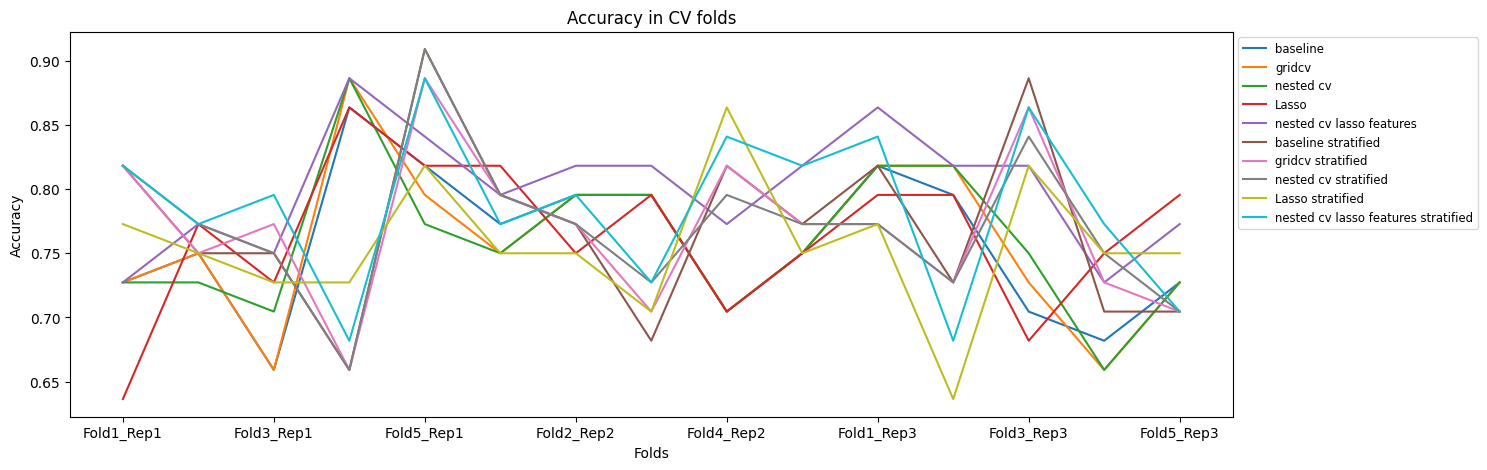

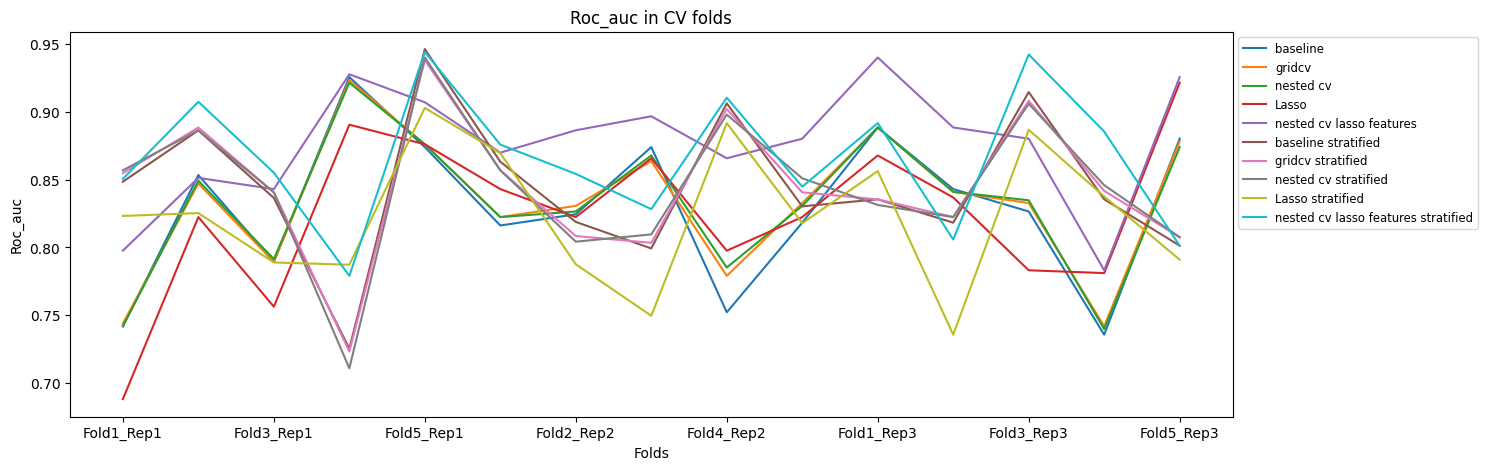

In [267]:
show_pipeline_folds(pipelines_results)

Finally, we check how importance of features changed when we tuned models.

In [268]:
show_pipeline_coef(pipelines_results)

name,baseline,gridcv,nested cv,Lasso,nested cv lasso features,baseline stratified,gridcv stratified,nested cv stratified,Lasso stratified,nested cv lasso features stratified
age,0.075,0.001,0.000,0.000,0.000,0.157,0.242,0.316,0.000,0.000
gender,-1.051,-1.064,-1.072,-0.033,-1.116,-0.472,-0.536,-0.602,0.000,0.000
comorbidity,-0.111,-0.083,-0.076,0.000,0.000,-0.389,-0.403,-0.416,-0.061,-0.361
diabetes,0.354,0.313,0.305,0.174,0.258,0.727,0.749,0.770,0.333,0.742
height,-0.045,0.000,0.000,0.000,0.000,0.000,-0.004,-0.112,0.000,0.000
weight,0.000,0.000,0.000,0.000,0.000,0.191,0.194,0.253,0.000,0.000
bmi,0.450,0.508,0.513,0.000,0.000,0.453,0.438,0.361,0.000,0.000
tbw,0.068,0.021,0.010,0.000,0.000,0.000,0.000,0.104,0.000,0.000
ecw,0.000,0.000,0.000,0.000,0.000,0.000,-0.040,-0.221,0.000,0.000
icw,0.873,0.882,0.892,0.389,1.118,0.949,0.907,0.919,0.570,1.531


### 8. Final Takeaways

Nested CV is essential: it guards against optimistic bias and provides more reliable performance estimates.

Stratification matters: balancing folds by gallstone + gender did not reduce CV scores in this dataset, but it ensures fairer evaluation across subgroups.

Regularization and feature selection: elastic net and LASSO help reduce noise and improve interpretability without major loss in accuracy.

**Key point: the project demonstrates end-to-end workflow (splitting, CV, nested CV, feature selection), with emphasis on methodology rather than raw metrics.**